In [1]:
from module import APOGEEDataset
import torch
from torch.utils.data import Dataset, DataLoader
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import torch
import torch.nn as nn


In [2]:
directory = '../../../projects/k-pop/spectra/apogee/dr17'
dataset = APOGEEDataset(directory, max_files=500)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)


In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        # Define the network layers
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(512),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(128),
            nn.Linear(128, output_dim)  # No activation in the output layer
        )

    def forward(self, z):
        return self.model(z)


In [4]:
def weighted_mse_loss(output, target, mask, sigma):
    """
    Custom weighted MSE loss.
    
    Parameters:
    - output (torch.Tensor): The generated spectra from the model.
    - target (torch.Tensor): The actual spectra.
    - mask (torch.Tensor): Mask array indicating gaps (values between 0 and 1).
    - sigma (torch.Tensor): Standard deviation of the noise for each spectral point.
    
    Returns:
    - torch.Tensor: The computed weighted MSE loss.
    """
    sigma_safe = sigma + 1e-8  # Add a small constant to avoid division by zero
    weights = mask / (sigma_safe**2)
    return (weights * (target - output) ** 2).mean()



In [5]:
mse_loss = nn.MSELoss()

In [6]:
def calculate_batch_sigma(batch):
    """
    Calculate the standard deviation of the flux values within a batch.
    
    Parameters:
    - batch (torch.Tensor): Batch of flux values.
    
    Returns:
    - float: Computed standard deviation of the batch.
    """
    return batch.std(dim=0)


In [7]:
# Hyperparameters
latent_dim = 50
output_dim = 8575  
learning_rate_gen = 0.1
learning_rate_latent = 0.01
weight_decay = 1e-4

# Initialize the generator
generator = Generator(latent_dim, output_dim)

# Latent vectors
latent_vectors = torch.randn((len(dataset), latent_dim), requires_grad=True)

# Optimizer setup with separate learning rates
optimizer = torch.optim.Adam([
    {'params': generator.parameters(), 'lr': learning_rate_gen, 'weight_decay': weight_decay},
    {'params': latent_vectors, 'lr': learning_rate_latent}
])



Training Loop

In [8]:
import matplotlib.pyplot as plt

def plot_spectra(real, generated, epoch, index):
    plt.figure(figsize=(10, 5))
    plt.plot(real, label='Real Spectra', color='blue')
    plt.plot(generated, label='Generated Spectra', color='red', linestyle='--')
    plt.title(f'Comparison of Real and Generated Spectra at Epoch {epoch}')
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')
    plt.legend()
    plt.show()
    # plt.savefig(f'spectra_comparison_epoch_{epoch}_index_{index}.png')  # Save the figure
    # plt.close()

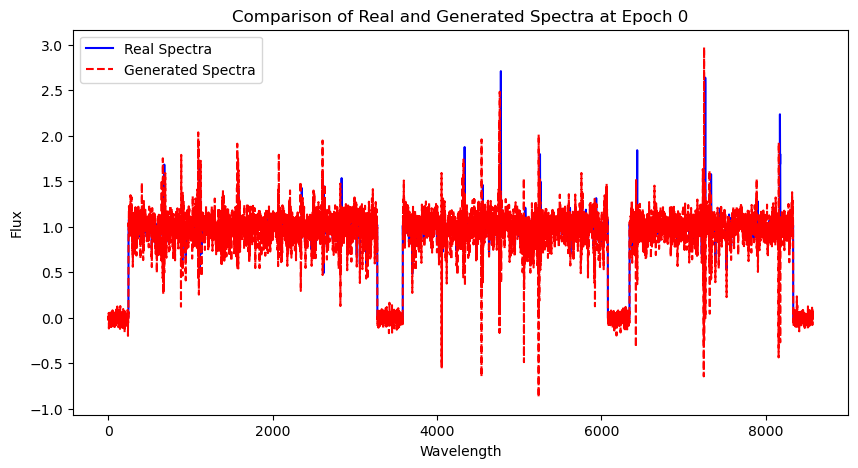

Epoch 0/200, Loss: 0.02554560825228691


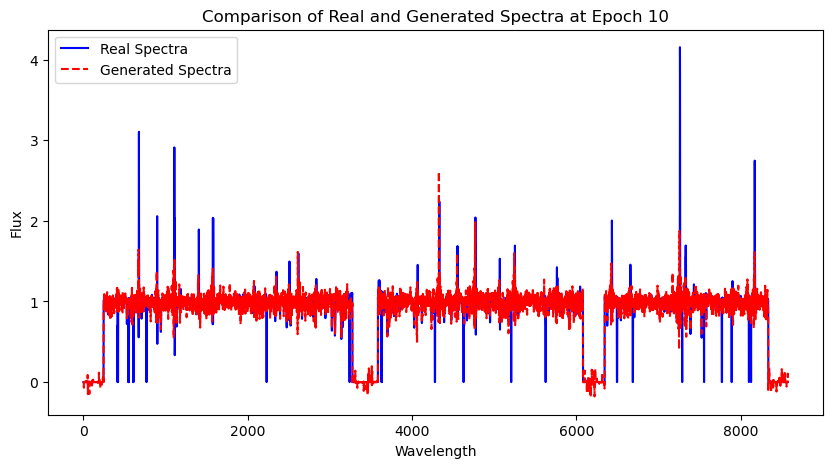

Epoch 10/200, Loss: 0.01687038689851761


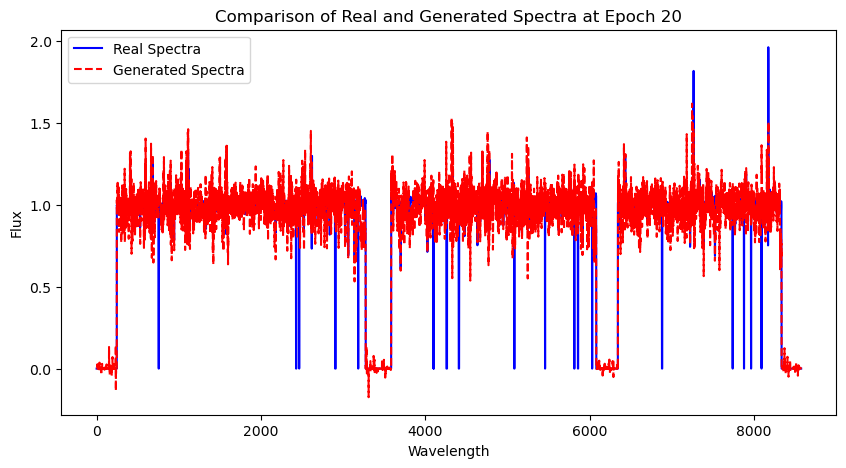

Epoch 20/200, Loss: 0.012639141641557217


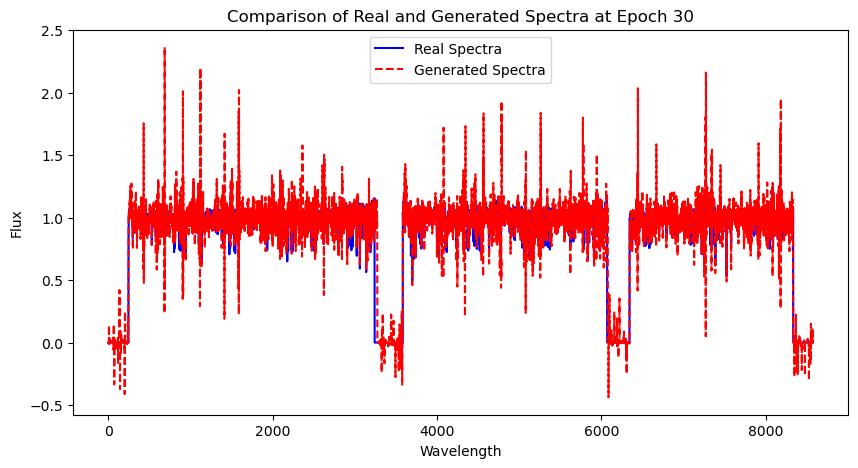

Epoch 30/200, Loss: 0.023709150031208992


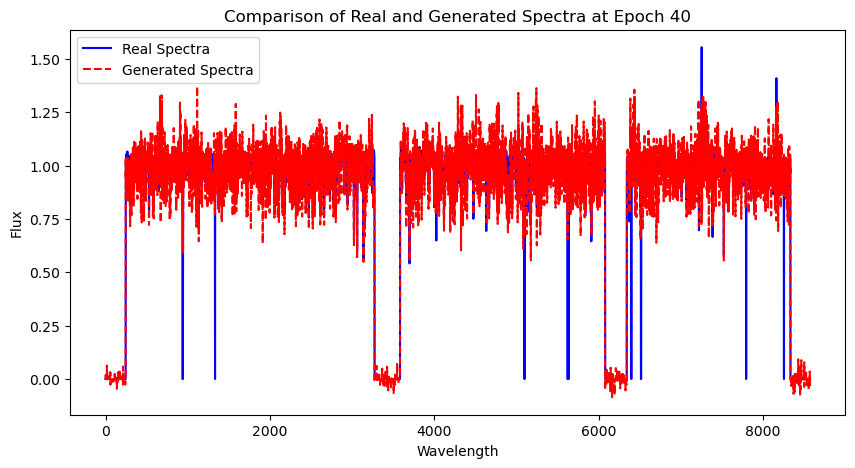

Epoch 40/200, Loss: 0.017079172655940056


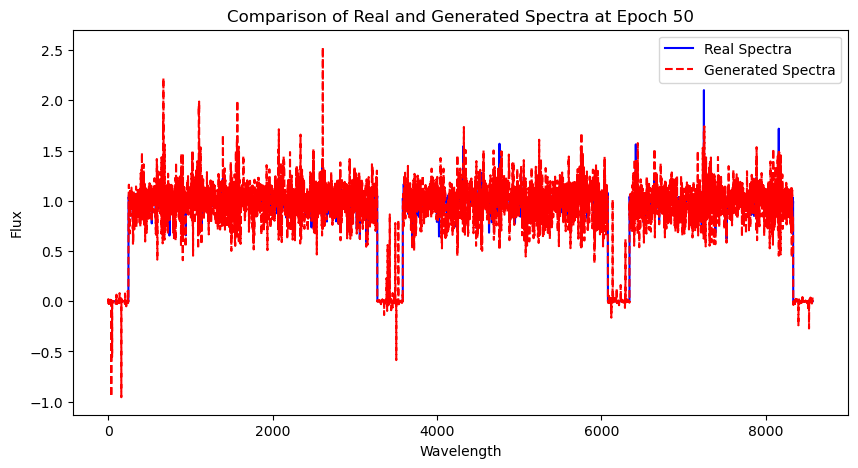

Epoch 50/200, Loss: 0.027326393872499466


In [ ]:
num_epochs = 200  # Total number of epochs
batch_size = 10  # Batch size for training
loss_values = []

# # DataLoader setup
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


for epoch in range(num_epochs):
    for batch_indices, batch in dataloader:
        optimizer.zero_grad()

       
        real_spectra = batch['flux']  
        mask = batch['flux_mask']
        sigma = batch['variation']  
        batch_indices = batch_indices  # Custom indexing support might be needed

        generated_spectra = generator(latent_vectors[batch_indices])
        
        # Calculate the custom weighted loss
        # loss = weighted_mse_loss(generated_spectra, real_spectra, mask, sigma)
        
        loss = mse_loss(generated_spectra, real_spectra)

        loss.backward()
        optimizer.step()
        
    # Store the loss value
    loss_values.append(loss.item())
    if epoch % 10 == 0: 
            plot_spectra(real_spectra[0].detach().numpy(), generated_spectra[0].detach().numpy(), epoch, 0)

    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
